# Logistic Regression

In [86]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


## Load raw data and plot

In [87]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/coffees/FTIR_instant_coffees.csv')
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
1,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705,1,Arabica
2,13.118324,13.507084,13.473495,12.871428,12.181919,11.239480,10.515672,10.468178,10.428742,10.212771,...,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559,1,Arabica
3,15.668409,15.803868,15.977607,15.569489,14.950423,14.029599,13.396739,13.092360,12.784991,12.829988,...,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201,1,Arabica
4,16.634960,17.055263,17.610495,17.211594,16.217897,15.287751,14.424133,13.928921,13.551499,13.288979,...,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584,1,Arabica


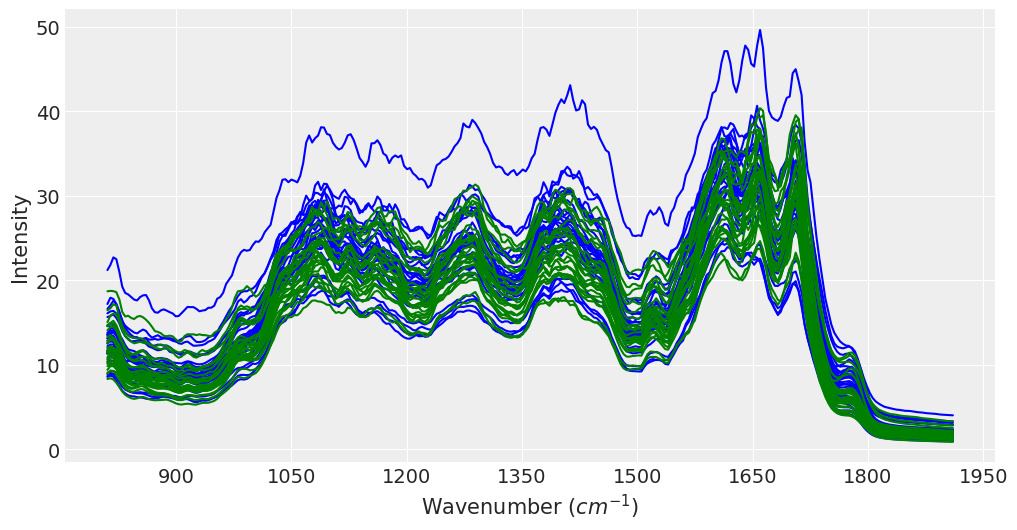

In [88]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'green'
    plt.plot(x_val, y_val[:-2], '-', color=col);

In [89]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data.reset_index(drop=True);
test_data.reset_index(drop=True);

# Model definition (Multiple Logistic Regression)

In [90]:
# standardize data
Y = pd.Categorical(train_data['label']).codes
x_n = train_data.columns[:-2]
x_s = train_data[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(44, 286)

In [92]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 2500/2500 [08:39<00:00,  4.36it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [93]:
#pm.model_to_graphviz(model_mlr)

# Model evaluation

In [94]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.167,11.953,-23.368,22.117,0.219,0.178,2981.0,2252.0,3008.0,2685.0,1.0
beta[0],0.216,9.833,-18.743,18.008,0.136,0.165,5249.0,1781.0,5267.0,2917.0,1.0
beta[1],1.186,10.021,-17.855,20.122,0.133,0.187,5648.0,1437.0,5652.0,2822.0,1.0
beta[2],0.970,10.072,-18.045,19.319,0.134,0.179,5647.0,1581.0,5626.0,2724.0,1.0
beta[3],1.403,9.793,-17.188,19.243,0.130,0.163,5648.0,1808.0,5638.0,2778.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[281],-1.474,9.776,-20.476,16.122,0.134,0.173,5321.0,1603.0,5314.0,2582.0,1.0
beta[282],-1.555,9.675,-20.127,16.796,0.125,0.169,5956.0,1643.0,5985.0,2713.0,1.0
beta[283],-1.485,9.724,-19.431,16.855,0.142,0.168,4695.0,1677.0,4708.0,2808.0,1.0
beta[284],-1.840,9.759,-19.402,16.955,0.143,0.184,4625.0,1407.0,4625.0,2349.0,1.0


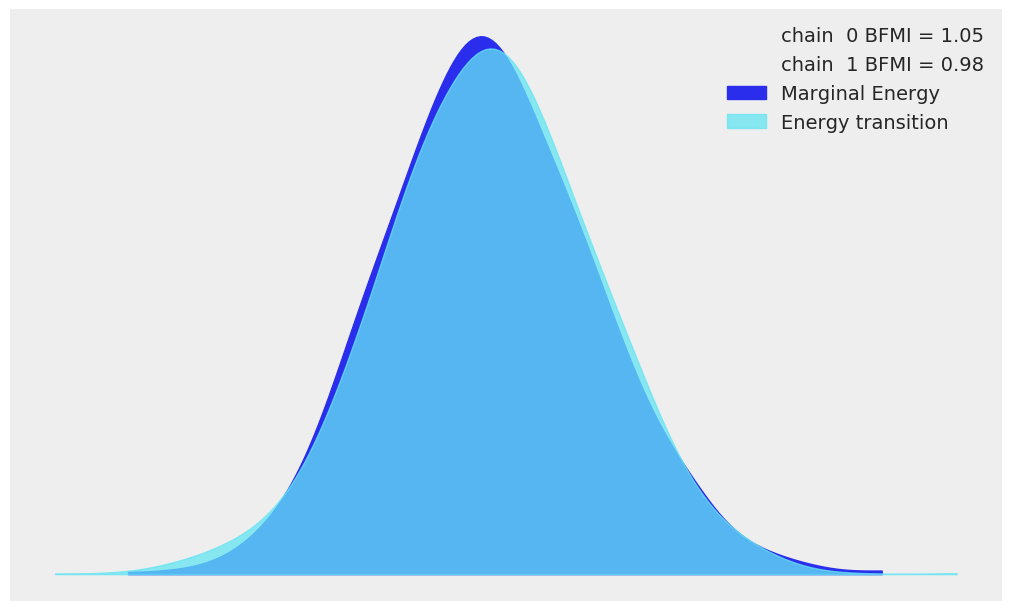

In [95]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [96]:
a = trace_mlr['alpha'].mean()
b = trace_mlr['beta'].mean(axis=0)

xt_n = test_data.columns[:-2]
xt_s = test_data[x_n].values
xt_s = (xt_s - xt_s.mean(axis=0)) / xt_s.std(axis=0)

mu_t = a + (b * xt_s).sum(axis=1)
yt_p = 1 / (1 + np.exp(-mu_t))

pt_y = np.zeros(len(xt_s))
lpt = [] 

for i in range(len(xt_s)):
    if (yt_p[i] < 0.5): 
        pt_y[i] = 0
        lpt.append('Arabica')
    else:
        pt_y[i] = 1
        lpt.append('Robusta')

test_data = test_data.assign(pred=pd.Series(p_y))
test_data = test_data.assign(pred_label=pd.Series(lp))
test_data.iloc[:,-4:]

,code,label,pred,pred_label
0,1,Arabica,0.0,Arabica
5,1,Arabica,0.0,Arabica
33,2,Robusta,1.0,Robusta
13,1,Arabica,0.0,Arabica
19,1,Arabica,0.0,Arabica
50,2,Robusta,1.0,Robusta
36,2,Robusta,1.0,Robusta
26,1,Arabica,0.0,Arabica
44,2,Robusta,1.0,Robusta
12,1,Arabica,0.0,Arabica


In [97]:
# prediction score
Yt = pd.Categorical(test_data['label']).codes
c = 0
for i in range(len(xt_s)):
    if test_data['label'].iloc[i] == lpt[i]:
        c += 1
        
f'{c / len(Yt):.2f}'

'1.00'